# Machine Learning for NLP: Project 2

Lucas Artaud & Iswarya Sivasubramaniam DIA 1

In [82]:
import os
import torch
import sentencepiece
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from huggingface_hub import hf_hub_download
from transformers import pipeline
from gensim.models import KeyedVectors

In [2]:
torch.cuda.is_available()

True

## Data loading

In [3]:
folder = 'Traduction avis clients'

df = pd.DataFrame()

for i in range(1, 36):
    filename = f'avis_{i}_traduit.xlsx'
    path = os.path.join(folder, filename)
    df = pd.concat([df, pd.read_excel(path)], ignore_index=True)

df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,train,06/09/2021,01/09/2021,"Best insurance, price, solutions, listening, s...",NaN,NaN
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,train,03/05/2021,01/05/2021,"I am generally satisfied, except that you have...",NaN,NaN
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,train,21/03/2021,01/03/2021,Very affordable price Several options are avai...,NaN,NaN
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"I satisfy the service, a very fast response fr...",NaN,NaN
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,train,29/01/2017,01/01/2017,"Customer for more than 25 years, very disappoi...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,test,24/08/2021,01/08/2021,"Hello, I have a bad experience with the Socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,Company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,NaN
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"Following a burglary on 01/22/2021, I am still...","Suite a un cambriolage le 22/01/2021, je suis ...",NaN
34433,NaN,lkio-110907,"Bonjour,\n\nJe constate qu'entre le moment de ...",Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"Hello,\n\nI note that between the time of my r...","Bonjour,\n\nJe constate qu'entre le moment de ...",NaN


## Data cleaning

In [4]:
df.drop(columns=['type', 'avis_en', 'avis_cor', 'avis_cor_en'], inplace=True)
df

,note,auteur,avis,assureur,produit,date_publication,date_exp
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017
...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,24/08/2021,01/08/2021
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,18/05/2021,01/05/2021
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,08/04/2021,01/04/2021
34433,NaN,lkio-110907,"Bonjour,\n\nJe constate qu'entre le moment de ...",Generali,assurances-professionnelles,19/04/2021,01/04/2021


In [5]:
df['avis'] = df['avis'].replace('\n', ' ', regex=True)
df

,note,auteur,avis,assureur,produit,date_publication,date_exp
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017
...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,24/08/2021,01/08/2021
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,18/05/2021,01/05/2021
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,08/04/2021,01/04/2021
34433,NaN,lkio-110907,"Bonjour, Je constate qu'entre le moment de ma...",Generali,assurances-professionnelles,19/04/2021,01/04/2021


In [6]:
df.isna().sum()

note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
date_publication        0
date_exp                0
dtype: int64

In [7]:
df.dropna(inplace=True)
df

,note,auteur,avis,assureur,produit,date_publication,date_exp
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017
...,...,...,...,...,...,...,...
24099,1.0,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto,22/03/2021,01/03/2021
24100,1.0,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation,06/12/2019,01/12/2019
24101,1.0,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante,14/04/2021,01/04/2021
24102,3.0,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto,11/07/2019,01/07/2019


In [8]:
df['note'] = df['note'].astype(int)

In [9]:
df_subset = df.head(10)

## Summary and translation

### Summary

In [10]:
summarizer_pipeline = pipeline("summarization", min_length=10, max_length=30)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
def summarizer(text):
    result = summarizer_pipeline(text)
    return result[0]['summary_text']

In [12]:
df_subset['résumé'] = df_subset['avis'].apply(summarizer)
df_subset

C:\Users\lucas\AppData\Local\Temp\ipykernel_23004\4062133327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['résumé'] = df_subset['avis'].apply(summarizer)


,note,auteur,avis,assureur,produit,date_publication,date_exp,résumé
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"Meilleurs assurances, prix, solutions, écoute..."
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"je suis globalement satisfait , sauf que vous..."
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,Prix tres abordable plusieurs options s'offre...
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"Cordialement. je satisfait du service, une ré..."
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"Client depuis plus de 25 years, très déçu de ..."
5,1,spam-62064,"Vente forcée par téléphone, prétextant des évè...",Néoliane Santé,sante,06/03/2018,01/03/2018,Néoliane va dire que c'est la faute de la pla...
6,3,ludovic-b-135966,Nouveau client satisfait du prix et des servic...,APRIL,sante,05/10/2021,01/10/2021,Nouveau client satisfait du prix et des servi...
7,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me...,SantéVet,animaux,17/09/2020,01/09/2020,Un assureur m'a contacté par telephone pour m...
8,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis nég...,Mercer,sante,12/01/2021,01/01/2021,"""Nous avons du retard mais vos demandes vont ..."
9,1,rezo31-62544,GENERALI ASSURANCES VIE PATRIMOINE Très mauvai...,Generali,vie,21/03/2018,01/03/2018,Generali ASSURANCES VIE PATRIMOINE . Très mau...


### Translation

In [13]:
fr_en_translator_pipeline = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

c:\Users\lucas\Desktop\GitHub\NLP_project2\NLP_venv\Lib\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
def fr_en_translator(text):
    result = fr_en_translator_pipeline(text)
    return result[0]['translation_text']

In [15]:
df_subset['traduction'] = df_subset['avis'].apply(fr_en_translator)
df_subset

C:\Users\lucas\AppData\Local\Temp\ipykernel_23004\3255095628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['traduction'] = df_subset['avis'].apply(fr_en_translator)


,note,auteur,avis,assureur,produit,date_publication,date_exp,résumé,traduction
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"Meilleurs assurances, prix, solutions, écoute...","Best insurance, prices, solutions, listening, ..."
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"je suis globalement satisfait , sauf que vous...","I'm generally satisfied, except that you have ..."
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,Prix tres abordable plusieurs options s'offre...,Very affordable prices several options are ava...
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"Cordialement. je satisfait du service, une ré...","I am satisfied with the service, a very quick ..."
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"Client depuis plus de 25 years, très déçu de ...","Customer for more than 25 years, very disappoi..."
5,1,spam-62064,"Vente forcée par téléphone, prétextant des évè...",Néoliane Santé,sante,06/03/2018,01/03/2018,Néoliane va dire que c'est la faute de la pla...,"Forcible sale by telephone, implying serious e..."
6,3,ludovic-b-135966,Nouveau client satisfait du prix et des servic...,APRIL,sante,05/10/2021,01/10/2021,Nouveau client satisfait du prix et des servi...,New customer satisfied with the price and the ...
7,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me...,SantéVet,animaux,17/09/2020,01/09/2020,Un assureur m'a contacté par telephone pour m...,An insurer contacted me by telephone to sell m...
8,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis nég...,Mercer,sante,12/01/2021,01/01/2021,"""Nous avons du retard mais vos demandes vont ...",I can only join the many negative reviews. I e...
9,1,rezo31-62544,GENERALI ASSURANCES VIE PATRIMOINE Très mauvai...,Generali,vie,21/03/2018,01/03/2018,Generali ASSURANCES VIE PATRIMOINE . Très mau...,GENERALI INSURANCE LIFE HERITAGE Very bad cust...


## Sentiment analysis

### Predict positive or negative

In [16]:
predict_pos_neg_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [17]:
def predict_pos_neg(text):
    result = predict_pos_neg_pipeline(text)
    return result[0]['label']

In [18]:
df_subset['pos_neg_pred'] = df_subset['avis'].apply(predict_pos_neg)
df_subset

C:\Users\lucas\AppData\Local\Temp\ipykernel_23004\2808179175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['pos_neg_pred'] = df_subset['avis'].apply(predict_pos_neg)


,note,auteur,avis,assureur,produit,date_publication,date_exp,résumé,traduction,pos_neg_pred
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"Meilleurs assurances, prix, solutions, écoute...","Best insurance, prices, solutions, listening, ...",POSITIVE
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"je suis globalement satisfait , sauf que vous...","I'm generally satisfied, except that you have ...",NEGATIVE
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,Prix tres abordable plusieurs options s'offre...,Very affordable prices several options are ava...,NEGATIVE
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"Cordialement. je satisfait du service, une ré...","I am satisfied with the service, a very quick ...",POSITIVE
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"Client depuis plus de 25 years, très déçu de ...","Customer for more than 25 years, very disappoi...",NEGATIVE
5,1,spam-62064,"Vente forcée par téléphone, prétextant des évè...",Néoliane Santé,sante,06/03/2018,01/03/2018,Néoliane va dire que c'est la faute de la pla...,"Forcible sale by telephone, implying serious e...",NEGATIVE
6,3,ludovic-b-135966,Nouveau client satisfait du prix et des servic...,APRIL,sante,05/10/2021,01/10/2021,Nouveau client satisfait du prix et des servi...,New customer satisfied with the price and the ...,POSITIVE
7,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me...,SantéVet,animaux,17/09/2020,01/09/2020,Un assureur m'a contacté par telephone pour m...,An insurer contacted me by telephone to sell m...,NEGATIVE
8,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis nég...,Mercer,sante,12/01/2021,01/01/2021,"""Nous avons du retard mais vos demandes vont ...",I can only join the many negative reviews. I e...,NEGATIVE
9,1,rezo31-62544,GENERALI ASSURANCES VIE PATRIMOINE Très mauvai...,Generali,vie,21/03/2018,01/03/2018,Generali ASSURANCES VIE PATRIMOINE . Très mau...,GENERALI INSURANCE LIFE HERITAGE Very bad cust...,NEGATIVE


### Predict star

In [19]:
predict_stars_pipeline = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

In [20]:
def predict_stars(text):
    result = predict_stars_pipeline(text[:512])
    return result[0]['label'][0]

In [21]:
df_subset['stars_pred'] = df_subset['avis'].apply(predict_stars)
df_subset

C:\Users\lucas\AppData\Local\Temp\ipykernel_23004\4274888546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['stars_pred'] = df_subset['avis'].apply(predict_stars)


,note,auteur,avis,assureur,produit,date_publication,date_exp,résumé,traduction,pos_neg_pred,stars_pred
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"Meilleurs assurances, prix, solutions, écoute...","Best insurance, prices, solutions, listening, ...",POSITIVE,5
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"je suis globalement satisfait , sauf que vous...","I'm generally satisfied, except that you have ...",NEGATIVE,4
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,Prix tres abordable plusieurs options s'offre...,Very affordable prices several options are ava...,NEGATIVE,4
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"Cordialement. je satisfait du service, une ré...","I am satisfied with the service, a very quick ...",POSITIVE,5
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"Client depuis plus de 25 years, très déçu de ...","Customer for more than 25 years, very disappoi...",NEGATIVE,1
5,1,spam-62064,"Vente forcée par téléphone, prétextant des évè...",Néoliane Santé,sante,06/03/2018,01/03/2018,Néoliane va dire que c'est la faute de la pla...,"Forcible sale by telephone, implying serious e...",NEGATIVE,1
6,3,ludovic-b-135966,Nouveau client satisfait du prix et des servic...,APRIL,sante,05/10/2021,01/10/2021,Nouveau client satisfait du prix et des servi...,New customer satisfied with the price and the ...,POSITIVE,4
7,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me...,SantéVet,animaux,17/09/2020,01/09/2020,Un assureur m'a contacté par telephone pour m...,An insurer contacted me by telephone to sell m...,NEGATIVE,1
8,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis nég...,Mercer,sante,12/01/2021,01/01/2021,"""Nous avons du retard mais vos demandes vont ...",I can only join the many negative reviews. I e...,NEGATIVE,1
9,1,rezo31-62544,GENERALI ASSURANCES VIE PATRIMOINE Très mauvai...,Generali,vie,21/03/2018,01/03/2018,Generali ASSURANCES VIE PATRIMOINE . Très mau...,GENERALI INSURANCE LIFE HERITAGE Very bad cust...,NEGATIVE,1


## Word2Vec

### Vectorise reviews

In [22]:
word2vec_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_frwiki_20180420_300d", filename="frwiki_20180420_300d.txt"))

In [23]:
def vectorize_sentence(sentence):
    words = sentence.split()  # Supposons que vos avis soient tokenisés par des espaces
    vectors = [word2vec_model[word] for word in words if word in word2vec_model.key_to_index]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return None

In [24]:
df['avis_vectorisé'] = df['avis'].apply(vectorize_sentence)
df

,note,auteur,avis,assureur,produit,date_publication,date_exp,avis_vectorisé
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"[0.24681999, 0.16044001, 0.06285334, -0.208206..."
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"[0.23545946, 0.0059973006, 0.07420811, -0.1272..."
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,"[0.2317636, 0.08315454, 0.08915909, -0.1495227..."
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"[0.20486194, -0.07464761, 0.013419046, -0.1545..."
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"[0.25692186, 0.04158, 0.057759054, -0.12208381..."
...,...,...,...,...,...,...,...,...
24099,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto,22/03/2021,01/03/2021,"[0.2766443, 0.0641923, 0.1040519, -0.056559607..."
24100,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation,06/12/2019,01/12/2019,"[0.20751432, 0.07767143, 0.0675238, -0.0785952..."
24101,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante,14/04/2021,01/04/2021,"[0.24621597, 0.058450233, 0.08599951, -0.08418..."
24102,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto,11/07/2019,01/07/2019,"[0.2087177, 0.039839808, 0.082023, -0.07003894..."


In [25]:
len(df.iloc[8]['avis_vectorisé'])

300

### Word2Vec Training

In [26]:
df.dropna(inplace=True)
df

,note,auteur,avis,assureur,produit,date_publication,date_exp,avis_vectorisé
0,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,06/09/2021,01/09/2021,"[0.24681999, 0.16044001, 0.06285334, -0.208206..."
1,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,03/05/2021,01/05/2021,"[0.23545946, 0.0059973006, 0.07420811, -0.1272..."
2,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,21/03/2021,01/03/2021,"[0.2317636, 0.08315454, 0.08915909, -0.1495227..."
3,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,10/06/2021,01/06/2021,"[0.20486194, -0.07464761, 0.013419046, -0.1545..."
4,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,29/01/2017,01/01/2017,"[0.25692186, 0.04158, 0.057759054, -0.12208381..."
...,...,...,...,...,...,...,...,...
24099,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto,22/03/2021,01/03/2021,"[0.2766443, 0.0641923, 0.1040519, -0.056559607..."
24100,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation,06/12/2019,01/12/2019,"[0.20751432, 0.07767143, 0.0675238, -0.0785952..."
24101,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante,14/04/2021,01/04/2021,"[0.24621597, 0.058450233, 0.08599951, -0.08418..."
24102,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto,11/07/2019,01/07/2019,"[0.2087177, 0.039839808, 0.082023, -0.07003894..."


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['avis_vectorisé'], df['note'], test_size=0.2, random_state=42)

In [28]:
X_train

15626    [0.31174093, 0.14216363, 0.10077727, -0.093154...
8878     [0.24600479, 0.08721428, 0.09521428, -0.109495...
16667    [0.19319166, 0.10429168, 0.051700007, -0.08747...
17013    [0.2423368, 0.026278943, 0.06603422, -0.068026...
5249     [0.22231737, 0.007386956, 0.13346955, -0.11153...
                               ...                        
21831    [0.24887681, 0.008658931, 0.035766065, -0.1146...
5455     [0.28149566, 0.087247826, 0.029582608, -0.0353...
870      [0.25010556, 0.06342223, 0.11823889, -0.080649...
15978    [0.19935709, 0.05392856, 0.07910613, -0.061081...
23934    [0.19332175, 0.12376522, 0.12292175, -0.072447...
Name: avis_vectorisé, Length: 19058, dtype: object

In [29]:
y_train

15626    3
8878     5
16667    3
17013    1
5249     3
        ..
21831    1
5455     4
870      4
15978    4
23934    3
Name: note, Length: 19058, dtype: int32

In [30]:
X_test

6561     [0.27608058, 0.036452785, 0.091547206, -0.0800...
9502     [0.22696859, 0.027782854, 0.067714274, -0.1365...
13743    [0.20729028, 0.038173612, 0.117847234, -0.0980...
5887     [0.19799216, 0.04137825, 0.05865999, -0.145024...
4825     [0.16443515, 0.07764595, 0.07364867, -0.018637...
                               ...                        
12218    [0.17921875, 0.12829375, 0.006593746, -0.07361...
2340     [0.18604119, 0.015882352, 0.030764706, -0.1331...
21909    [0.22369047, 0.021914288, 0.07593333, -0.13747...
19454    [0.28505498, -0.055105, 0.12777501, -0.1451200...
19163    [0.2615892, 0.04724865, 0.077591896, -0.143429...
Name: avis_vectorisé, Length: 4765, dtype: object

In [31]:
y_test

6561     1
9502     3
13743    4
5887     1
4825     4
        ..
12218    5
2340     4
21909    5
19454    3
19163    2
Name: note, Length: 4765, dtype: int32

In [32]:
model = LinearRegression()
model.fit(X_train.tolist(), y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test.tolist())
y_pred

array([1.5397983, 2.389738 , 2.470921 , ..., 3.3712535, 1.9956107,
       1.2819839], dtype=float32)

In [34]:
y_pred = np.round(y_pred).astype(int)
y_pred

array([2, 2, 2, ..., 3, 2, 1])

In [35]:
print('RMSE =', mean_squared_error(y_test, y_pred, squared=False))

RMSE = 1.0894899988079851


In [36]:
print('R² =', r2_score(y_test, y_pred))

R² = 0.49437446746814795


### Visualization of embeddings with Matplotlib

In [37]:
embeddings = np.array(df['avis_vectorisé'].tolist())
embeddings

array([[ 0.24681999,  0.16044001,  0.06285334, ..., -0.08451334,
        -0.03200667, -0.05122667],
       [ 0.23545946,  0.0059973 ,  0.07420811, ..., -0.06328376,
        -0.07754324, -0.14190538],
       [ 0.2317636 ,  0.08315454,  0.08915909, ...,  0.05433182,
        -0.10796363, -0.12736364],
       ...,
       [ 0.24621597,  0.05845023,  0.08599951, ..., -0.0324128 ,
        -0.13283989, -0.08053696],
       [ 0.2087177 ,  0.03983981,  0.082023  , ...,  0.00057788,
        -0.11693095, -0.09139115],
       [ 0.25398645,  0.04221017,  0.08172711, ...,  0.01838305,
        -0.12025254, -0.14518476]], dtype=float32)

In [38]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
embeddings_2d

array([[ 36.810085 , -10.491382 ],
       [ -5.843158 , -32.51349  ],
       [-13.591599 ,   6.4499483],
       ...,
       [-10.510107 ,  35.090614 ],
       [-16.050161 ,  -8.276429 ],
       [ -0.6935775,   9.366311 ]], dtype=float32)

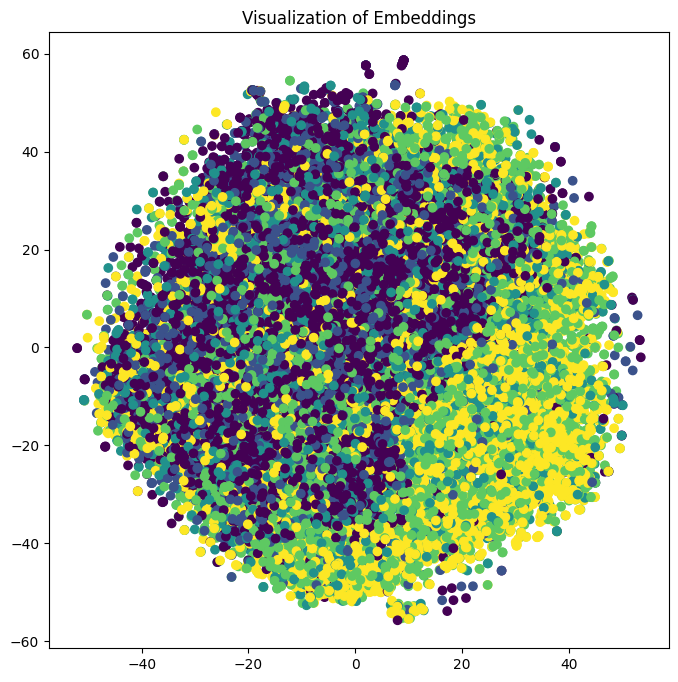

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['note'])

plt.title("Visualization of Embeddings")
plt.show()

### Implementation of Euclidean distance and cosine similarity

In [83]:
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

In [84]:
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

In [85]:
euclidean_distances = []
cosine_similarities = []
for i in range(1000):
    for j in range(i + 1, 1000):
        euclidean_distances.append(euclidean_distance(embeddings_2d[i], embeddings_2d[j]))
        cosine_similarities.append(cosine_similarity(embeddings_2d[i], embeddings_2d[j]))

In [88]:
euclidean_distances

[48.00284,
 53.17272,
 51.662613,
 36.269188,
 36.261818,
 53.834236,
 59.54011,
 25.570026,
 41.52418,
 34.414837,
 40.409286,
 18.529665,
 20.711159,
 41.421467,
 39.45603,
 66.79197,
 20.792683,
 23.21221,
 63.28783,
 50.021687,
 56.042618,
 45.659176,
 40.670883,
 63.518665,
 52.947086,
 48.48489,
 46.243168,
 43.257164,
 38.414536,
 60.33191,
 38.163376,
 58.20109,
 37.350132,
 23.24632,
 22.222471,
 27.589529,
 45.772705,
 44.57565,
 2.9002452,
 53.372803,
 67.315544,
 64.44188,
 65.7025,
 9.870334,
 65.89171,
 36.957336,
 14.133662,
 49.900383,
 8.94543,
 38.356342,
 40.21238,
 27.864267,
 40.088085,
 59.34323,
 62.221344,
 42.471973,
 51.817745,
 59.904892,
 48.527767,
 36.72234,
 16.474125,
 29.238342,
 31.34439,
 60.671658,
 77.258385,
 5.5352497,
 31.837286,
 28.4497,
 53.03563,
 61.44668,
 26.514162,
 41.399414,
 50.490147,
 61.871666,
 65.58039,
 43.919292,
 58.094517,
 64.38703,
 54.158165,
 12.040487,
 70.367455,
 67.73692,
 14.9492855,
 26.019527,
 53.620434,
 56.58259,

In [90]:
print('Average euclidean distance for 1000 first embeddings =', np.mean(euclidean_distances))

Average euclidean distance for 1000 first embeddings = 41.264545


In [91]:
cosine_similarities

[0.09966939,
 -0.9863472,
 0.18477836,
 0.38640273,
 0.32419726,
 -0.13678503,
 -0.47903797,
 0.74671817,
 -0.6479238,
 0.4499832,
 0.539971,
 0.94775444,
 0.86071444,
 0.123095796,
 0.031446084,
 -0.93510944,
 0.85281557,
 0.7965372,
 -0.67848563,
 0.051842593,
 -0.6450895,
 -0.97303265,
 0.43635023,
 -0.899606,
 -0.9929242,
 -0.6223553,
 -0.5484796,
 -0.07514593,
 0.041428287,
 -0.20801681,
 0.24031036,
 0.08539976,
 0.35839966,
 0.8019083,
 0.83840036,
 0.9254147,
 -0.45565864,
 0.45461673,
 0.99723744,
 0.28976396,
 -0.39971235,
 -0.67194206,
 -0.5381185,
 0.9673802,
 -0.61159974,
 0.6077993,
 0.9980107,
 -0.16062656,
 0.97520685,
 0.36619914,
 0.036598302,
 0.7676533,
 0.24441062,
 -0.99860704,
 -0.57627684,
 -0.07354221,
 -0.15092471,
 -0.7943826,
 -0.7704692,
 0.34908226,
 0.99998456,
 0.7787738,
 0.6799394,
 -0.6478415,
 -0.9005093,
 0.9927787,
 0.79205304,
 0.69488615,
 -0.17607035,
 -0.6396881,
 0.999752,
 -0.9353572,
 -0.9784263,
 -0.8845116,
 -0.87090975,
 0.25073335,
 -0.4

In [94]:
print('Average cosine similarity for 1000 first embeddings =', np.mean(cosine_similarities))

Average cosine similarity for 1000 first embeddings = -0.00033612075
